In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import emcee
import corner
import scipy.optimize as op

In [8]:
_ = np.genfromtxt('../data/data-from-schaefer-paper.csv', unpack=True, skip_header=1, delimiter=',')
x = _[0]
y = _[4]
yerr = _[5]

In [14]:
# some useful functions

def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    m, b, lnf = theta
    if -1. < m < 1. and 0.0 < b < 1000.0 and -10.0 < lnf < 10.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

Least-squares results:
    m = 0.0016543911499056208 ± 0.00013041348048940934 
    b = 9.159332306378928 ± 0.25324574977766534 



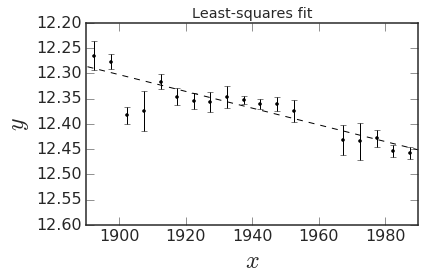

In [12]:
xl = np.array([1880, 1995])
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
print("""Least-squares results:
    m = {0} ± {1} 
    b = {2} ± {3} 
""".format(m_ls, np.sqrt(cov[1, 1]), b_ls, np.sqrt(cov[0, 0])))

# Plot the least-squares result.
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(xl, m_ls*xl+b_ls, "--k")
plt.xlim(1890, 1990)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(12.6,12.2)
plt.title('Least-squares fit')
plt.tight_layout()

In [16]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [0.01,12,0.01], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]


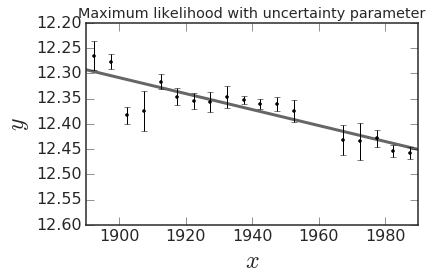

In [18]:
xl = np.array([1880, 1995])
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(xl, m_ml*xl+b_ml, "k", lw=3, alpha=0.6)
plt.xlim(1890, 1990)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(12.6,12.2)
plt.title('Maximum likelihood with uncertainty parameter')
plt.tight_layout()

In [19]:
# mcmc
ndim, nwalkers = 3, 300
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [20]:
# sample
s = sampler.run_mcmc(pos, 5000)

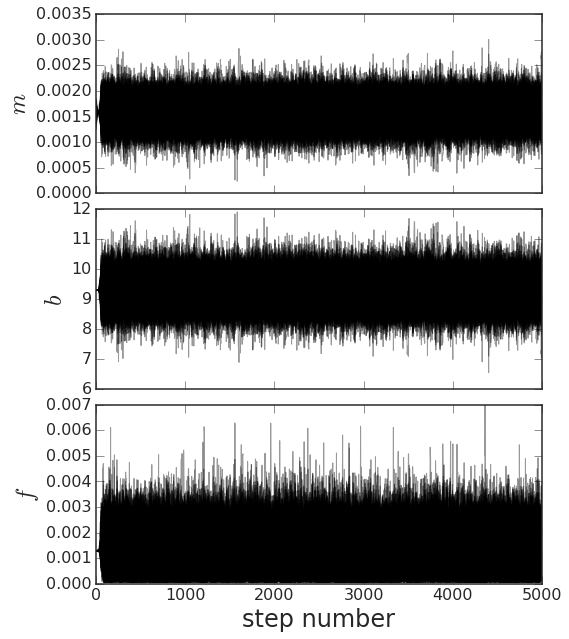

In [21]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 9))
axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4)
axes[0].set_ylabel("$m$")

axes[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
axes[1].set_ylabel("$b$")

axes[2].plot(np.exp(sampler.chain[:, :, 2]).T, color="k", alpha=0.4)
axes[2].set_ylabel("$f$")
axes[2].set_xlabel("step number")

fig.tight_layout(h_pad=0.0)

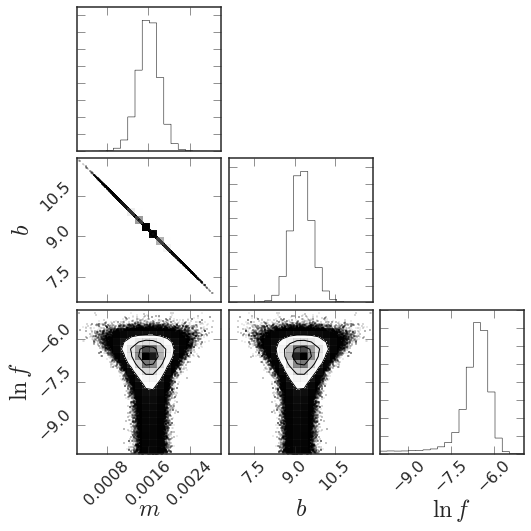

In [24]:
burnin = 100
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"], )

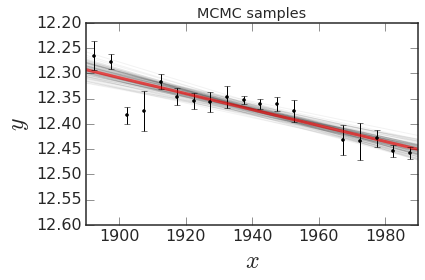

In [26]:
plt.figure()
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.05)
#plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ml*xl+b_ml, "r", lw=3, alpha=0.6)
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlim(1890, 1990)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(12.6,12.2)
plt.title('MCMC samples')
plt.tight_layout()

In [27]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print("""MCMC result:
    m = {0[0]} +{0[1]} -{0[2]} 
    b = {1[0]} +{1[1]} -{1[2]} 
    f = {2[0]} +{2[1]} -{2[2]} 
""".format(m_mcmc, b_mcmc, f_mcmc))

MCMC result:
    m = 0.0016074843794684473 +0.00019418627922167058 -0.00020190706125166702 
    b = 9.25284152585051 +0.3919110294589032 -0.3767249683178502 
    f = 0.001379191803736003 +0.0005787411821098806 -0.0005455315558096959 



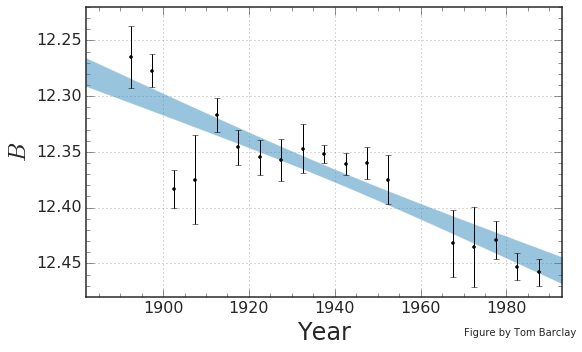

In [30]:
size=300000
xval = np.arange(1880,2000,1)
savearr = np.zeros([size,len(xval)])
for i, [m, b, lnf] in enumerate(samples[np.random.randint(len(samples), size=size)]):
    savearr[i] = m*xval+b

pc = np.percentile(savearr,[16, 50, 84], axis=0)

fig, ax1 = plt.subplots(1, 1, figsize=[8,5], sharex=False, sharey=False)
ax1.fill_between(xval, pc[0], pc[2], alpha=0.5)
ax1.errorbar(x, y, yerr=yerr, fmt=".k")
ax1.minorticks_on()
ax1.grid()
ax1.set_xlim(1882, 1993)
ax1.set_ylim(12.48, 12.22)
ax1.set_xlabel('Year')
ax1.set_ylabel('$B$ ')
ax1.text(1970,12.515,'Figure by Tom Barclay')
fig.tight_layout()
fig.savefig('../figs/WFT_mcmc.png', dpi=150)